## Day 10 - Image Classification with ResNet

The neural network you trained for the Cifar data sets is relatively small and only uses a few convolution+relu+pooling layers (and of course the input pictures are small). 

ResNet is a large-scale model trained on the ImageNet dataset. https://www.image-net.org/
You can explore ImageNet here: https://navigu.net/#imagenet
ImageNet contains about 1.2 Million images and each is linked to a specific synset (a set of words referring to the same concept) in an dictionary WordNet. But ResNet is trained on labeling images with 1000 labels from WordNet. 

ResNet is similar to the simple CNNs you built yourself, but much larger. There are different versions -- the most popular one, ResNet-50, has 50 "layers" or blocks. Each block consists of three (convolution + batch norm) steps, with a final reLU activation. Note that there is no pooling until the very end, before feeding the final feature map representation into the classifier. 
A core innovation in ResNet is the idea of residual connections. The input of each block is added to the output. 
This allows the model to learn the "difference" between the input and output, rather than mapping to the output directly. Residual connections make learning in deep neural networks more stable (by countering vanishing gradients). They are common in most deep neural network architectures, including transformers. 


<img src="http://www.cs.columbia.edu/~bauer/shape/resnet_block.png" width=200px>

The torchvision module already contains a resnet50 implementation as a pyTorch module, that we can just load.
All we need to do to classify an image: 
* preprocess the image and convert to torch tensor
* pass the image to the pretrained resnet model, this will output a softmax over the 1k output classes
* take the argmax of the softmax distribution to get the label
* decode the labels. The label index is here:

In [2]:
!wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt

--2025-08-08 14:58:05--  https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10472 (10K) [text/plain]
Saving to: ‘imagenet_classes.txt’

imagenet_classes.tx 100%[===================>]  10.23K  --.-KB/s    in 0s      

2025-08-08 14:58:05 (55.8 MB/s) - ‘imagenet_classes.txt’ saved [10472/10472]



In [8]:
def get_label_index(filename):
    with open("imagenet_classes.txt", "r") as f: 
        return {i:name.strip() for i,name in enumerate(f)}

label_idx = get_label_index("imagenet_classes.txt")

In [17]:
label_idx[999]

'toilet tissue'

In [39]:
from torchvision import models, transforms
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F


# Load pre-trained ResNet-50 model from torchvision
model = models.resnet50(weights="IMAGENET1K_V1") 
model.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

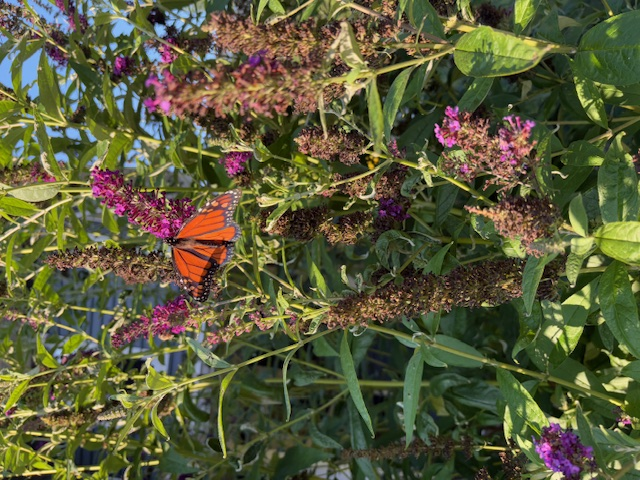

In [30]:
image =  Image.open("IMG_4852.jpg").convert("RGB")
image

In [31]:
# Resnet images need to be of size 3x224x224
# - Resize shorter side to 256 (we will crop some of the sides).
# - Center crop to 224x224
# - Convert to tensor and normalize with ImageNet mean / stdev (pre-calculated)
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),
])

input_tensor = preprocess(image)
input_batch = input_tensor.unsqueeze(0) # input must be a batch

# Pass image to model
with torch.no_grad():
    output = model(input_batch)  # output shape: [1, 1000] (ImageNet classes)
    probabilities = F.softmax(output[0], dim=0) #softmax over first image

_, label = torch.topk(probabilities, 1)
print(f"Predicted label: {label_idx[label.item()]}")


### Web Frontend for ResNet

Build a web application that allows uploading a photo through an HTML form, classifies the image using resnet in the backend, and then prints out the classification result (and also maybe display the image). 

Hint: Upload the code above to your LLM of choice and ask it to generate a minimal flask application. Flask is a web framework for Python. 


Make sure you run the app as follows:     

`app.run(debug=True, port="6668", host="0.0.0.0", use_reloader=False)`

You can find the hostname for your codio box under Project -> Box Info in the menu. 